In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import sys
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns
from itertools import combinations
from torch.utils.data import Dataset, DataLoader

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_file

In [ ]:
class EvaluationDataset(Dataset):
    def __init__(self, preds, cluster_labels=[], pred_labels=None):
        n_regions = [p.shape[1] for p in preds]
        assert len(set(n_regions)) == 1
        self.n_regions = n_regions[0]
        self.data = preds
        self._cluster_labels = cluster_labels
        if pred_labels is not None:
            self.pred_labels = pred_labels
        else:
            self.pred_labels = range(1, len(self.data)+1)

    def __len__(self):
        return self.n_regions

    @property
    def cluster_labels(self):
        if len(self._cluster_labels) > 0:
            labels = []
            for i in self.pred_labels:
                labels.extend(list([f"{c}_{i}" for c in self._cluster_labels]))
            return labels
        else:
            return []

    def __getitem__(self, idx: int):
        return list([torch.from_numpy(self.data[i][:, idx]) for i in range(len(self.data))])

In [ ]:
def evaluate_corr(evaluation_datasets):
    n_batches = 0
    n_clusters = len(evaluation_datasets.cluster_labels)
    results = torch.zeros(n_clusters, n_clusters)
    _iter = DataLoader(evaluation_datasets, batch_size=32, shuffle=True, num_workers=1)
    
    for ds in _iter:
        n_batches += 1
        stacked_ds = torch.hstack(ds).T
        results += stacked_ds.corrcoef()
    print(ds[0].shape, torch.hstack(ds).shape, torch.hstack(ds).T.shape)
    return results / n_batches

In [ ]:
liver_dec_jobs = {
    # Group A: default
    18338: "A_",

    # Group B1: α
    25332: "B_1A",  # α=0
    25331: "B_1B",  # α=0.01
    25330: "B_1C",  # α=0.05
    25329: "B_1D",  # α=0.1
    25328: "B_1E",  # α=0.5
    25327: "B_1J",  # α=100
    25326: "B_1I",  # α=50
    25325: "B_1H",  # α=20
    25324: "B_1G",  # α=10
    25323: "B_1F",  # α=5

    # Group B2: batch size
    25337: "B_2A",  # batch size = 256
    25336: "B_2B",  # batch size = 128
    25334: "B_2C",  # batch size = 64
    25333: "B_2D",  # batch size = 16
    
    # Group C: reference quality
    25391: "C_A",   # 7.5k
    25643: "C_B",   # 5k
    25393: "C_C",   # 2.5k
    25474: "C_D",   # 1k
}
liver_dec_job_files = {k: get_bioqueue_file("{{History:%d-merged_preds.h5}}" % k) for k in liver_dec_jobs.keys()}
liver_dec_job_handles = {k: h5py.File(liver_dec_job_files[k], "r") for k in liver_dec_job_files.keys()}
per_job_regions = {k: h["regions"] for k, h in liver_dec_job_handles.items()}
# sanity check
for i, j in combinations(liver_dec_job_handles.keys(), 2):
    assert np.allclose(per_job_regions[i][:, 1] == 1, per_job_regions[j][:, 1] == 1)
# extract cluster names
cluster_names = {k: h["preds"].attrs["cluster_names"].tolist() for k, h in liver_dec_job_handles.items()}
_lists = list(cluster_names.values())
assert all(lst == _lists[0] for lst in _lists)
# get counts prediction
per_job_counts_pred = {k: np.sum(np.nan_to_num(np.abs(h["preds"][:]), nan=0.0, posinf=0., neginf=0.), -1).sum(-1) for k, h in liver_dec_job_handles.items()}
for h in liver_dec_job_handles.values(): h.close()

In [ ]:
ds = EvaluationDataset(
    [per_job_counts_pred[k] for k in liver_dec_jobs.keys()], 
    cluster_labels=_lists[0],
    pred_labels=[liver_dec_jobs[k] for k in liver_dec_jobs.keys()]
)
cor_mat = evaluate_corr(ds)
cor_df = pd.DataFrame(cor_mat, columns=ds.cluster_labels, index=ds.cluster_labels).sort_index(axis=1, ascending=False).sort_index(axis=0, ascending=False)
cor_df.head()

torch.Size([25, 4]) torch.Size([25, 76]) torch.Size([76, 25])


,macrophage_C_D,macrophage_C_C,macrophage_C_B,macrophage_C_A,macrophage_B_2D,macrophage_B_2C,macrophage_B_2B,macrophage_B_2A,macrophage_B_1J,macrophage_B_1I,...,endothelial-cell_B_1I,endothelial-cell_B_1H,endothelial-cell_B_1G,endothelial-cell_B_1F,endothelial-cell_B_1E,endothelial-cell_B_1D,endothelial-cell_B_1C,endothelial-cell_B_1B,endothelial-cell_B_1A,endothelial-cell_A_
macrophage_C_D,1.000000,0.824196,0.855140,0.862424,0.860839,0.861028,0.848016,0.857744,0.861171,0.863746,...,0.649716,0.631235,0.635163,0.652447,0.637259,0.619468,0.623497,0.640537,0.613347,0.629731
macrophage_C_C,0.824196,1.000000,0.927013,0.928689,0.932567,0.933864,0.921056,0.933515,0.938241,0.939107,...,0.684832,0.668767,0.672364,0.681839,0.673046,0.662809,0.668140,0.681390,0.659049,0.670545
macrophage_C_B,0.855140,0.927013,1.000000,0.972646,0.972977,0.975257,0.964369,0.969602,0.972671,0.973539,...,0.718031,0.697203,0.703827,0.718386,0.703190,0.686094,0.693801,0.711400,0.683123,0.699306
macrophage_C_A,0.862424,0.928689,0.972646,1.000000,0.979694,0.985389,0.974316,0.975424,0.977845,0.979008,...,0.730056,0.704611,0.712438,0.733273,0.712954,0.691015,0.699084,0.719663,0.686260,0.705624
macrophage_B_2D,0.860839,0.932567,0.972977,0.979694,1.000000,0.990239,0.985689,0.990788,0.990008,0.988286,...,0.727962,0.710548,0.713682,0.730594,0.718467,0.699990,0.705230,0.722424,0.693583,0.709934


In [9]:
cor_df.columns

Index(['macrophage_C_D', 'macrophage_C_C', 'macrophage_C_B', 'macrophage_C_A',
       'macrophage_B_2D', 'macrophage_B_2C', 'macrophage_B_2B',
       'macrophage_B_2A', 'macrophage_B_1J', 'macrophage_B_1I',
       'macrophage_B_1H', 'macrophage_B_1G', 'macrophage_B_1F',
       'macrophage_B_1E', 'macrophage_B_1D', 'macrophage_B_1C',
       'macrophage_B_1B', 'macrophage_B_1A', 'macrophage_A_', 'hepatocyte_C_D',
       'hepatocyte_C_C', 'hepatocyte_C_B', 'hepatocyte_C_A', 'hepatocyte_B_2D',
       'hepatocyte_B_2C', 'hepatocyte_B_2B', 'hepatocyte_B_2A',
       'hepatocyte_B_1J', 'hepatocyte_B_1I', 'hepatocyte_B_1H',
       'hepatocyte_B_1G', 'hepatocyte_B_1F', 'hepatocyte_B_1E',
       'hepatocyte_B_1D', 'hepatocyte_B_1C', 'hepatocyte_B_1B',
       'hepatocyte_B_1A', 'hepatocyte_A_', 'fibroblast_C_D', 'fibroblast_C_C',
       'fibroblast_C_B', 'fibroblast_C_A', 'fibroblast_B_2D',
       'fibroblast_B_2C', 'fibroblast_B_2B', 'fibroblast_B_2A',
       'fibroblast_B_1J', 'fibroblast_B_1I',

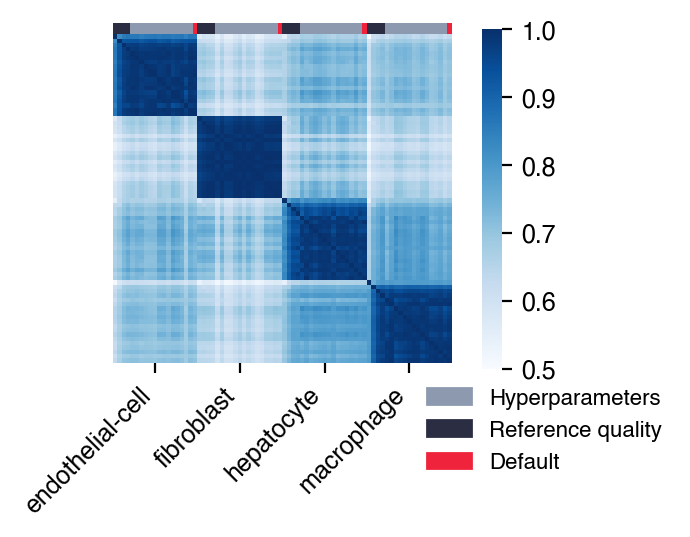

In [10]:
condition_color_map = {"A": "#ef233c", "B": "#8d99ae", "C": "#2b2d42"}
g = sns.clustermap(
    cor_df, method="single",
    cmap="Blues", figsize=(2, 2), 
    row_cluster=False, col_cluster=False, 
    col_colors=[condition_color_map[c.split("_")[1]] for c in cor_df.index], 
    yticklabels=False, xticklabels=False, 
    dendrogram_ratio=0.001, 
    vmin=0.5,
    linewidths=0.0,
    cbar_pos=(1, 0.06, 0.05, .85) # (left, bottom, width, height)
)

per_group_len = cor_df.columns.shape[0] // len(_lists[0])
mid_idx = per_group_len / 2
g.ax_heatmap.set_xticks(
    [i*per_group_len+mid_idx for i in range(len(_lists[0]))], 
    _lists[0], 
    rotation=45, ha="right")

# legend for col_colors
label_remapping = {"B": "Hyperparameters", "C": "Reference quality", "A": "Default"}
legend_handles = [
    patches.Patch(color=condition_color_map[group], label=label)
    for group, label in label_remapping.items()
]
# Position the legend manually relative to the heatmap
g.ax_heatmap.legend(
    handles=legend_handles,
    bbox_to_anchor=(0.9, -0.05),  # adjust position as needed
    loc='upper left',
    borderaxespad=0
)